In [9]:
import os
import numpy as np
import tensorflow as tf
from keras.applications import MobileNetV2
from keras.layers import GlobalAveragePooling2D, Dense, Conv2D, MaxPooling2D, Flatten, Input
from keras.models import Model
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

Set Up Model with different input using channels 

In [18]:
from keras.models import Model
from keras.layers import Input, Dense, GlobalAveragePooling2D, concatenate, Embedding, Reshape
from keras.applications import MobileNetV2

# Define shared layers
shared_conv = GlobalAveragePooling2D()

# Create input channels for image and JSON data
image_input = Input(shape=(256, 256, 3), name='image_input')
json_input = Input(shape=(None,), name='json_input')

# Image branch
# Define shared MobileNetV2 base model for image
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
image_features = base_model(image_input)
image_features = shared_conv(image_features)
image_branch = Dense(64, activation='relu')(image_features)
class_output = Dense(1, activation='sigmoid', name='class_output')(image_branch)

# JSON branch using Embedding layer
json_embedding = Embedding(input_dim=500, output_dim=4)(json_input)
# You can adjust input_dim as needed
json_reshaped = Reshape((1, 1, 4))(json_embedding)  # Reshape to match image feature shape
json_features = shared_conv(json_reshaped)
json_branch = Dense(64, activation='relu')(json_features)
bbox_output = Dense(4, activation='linear', name='bbox_output')(json_branch)


# Combine the outputs of both branches
combined_output = concatenate([class_output, bbox_output], name='combined_output')

# Create the final model
model = Model(inputs=[image_input, json_input], outputs=combined_output)

# Summary of the model
model.summary()


Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 json_input (InputLayer)        [(None, None)]       0           []                               
                                                                                                  
 image_input (InputLayer)       [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding_2 (Embedding)        (None, None, 4)      2000        ['json_input[0][0]']             
                                                                                                  
 mobilenetv2_1.00_224 (Function  (None, 8, 8, 1280)  2257984     ['image_input[0][0]']      

Train Image Classification with Imagedata Generator

In [11]:
from keras.preprocessing.image import ImageDataGenerator

TRAINING_DIR = "C:\\Users\\Armand S\\Documents\\Kerja Praktek\\RCNN\\train"
training_datagen = ImageDataGenerator(rescale=1./255)

VALIDATION_DIR = "C:\\Users\\Armand S\\Documents\\Kerja Praktek\\RCNN\\val"
validation_datagen = ImageDataGenerator(rescale=1./255)

image_train_generator = training_datagen.flow_from_directory(
    TRAINING_DIR,
    target_size=(256, 256),
    class_mode='sparse',      # Use 'sparse' for single-class classification
    classes=['meningioma'],  
    batch_size=32
)

image_validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_DIR,
    target_size=(256, 256),
    class_mode='sparse',      # Use 'sparse' for single-class classification
    classes=['meningioma'],  
    batch_size=32
)


Found 0 images belonging to 1 classes.
Found 0 images belonging to 1 classes.


In [5]:
from keras.callbacks import CSVLogger

image_model = Model(inputs=image_input, outputs=class_output)
image_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Callback to log training metrics to CSV
csv_logger = CSVLogger('training_metrics_classifier.csv', separator=',', append=False)

# Train the model
history = image_model.fit (image_train_generator,
                    epochs=7,
                    steps_per_epoch=len(image_train_generator),
                    validation_data=image_validation_generator,
                    validation_steps=len(image_validation_generator),
                    callbacks=[csv_logger])

# Save the trained model
model.save("C:\\Users\\Armand S\\Documents\\Kerja Praktek\\RCNN\\classifiermodel.h5")


Epoch 1/7
96/96 [==============================] - 365s 4s/step - loss: 0.0076 - accuracy: 0.9951 - val_loss: 2.4842e-05 - val_accuracy: 1.0000
Epoch 2/7
96/96 [==============================] - 243s 3s/step - loss: 1.5126e-07 - accuracy: 1.0000 - val_loss: 4.1418e-05 - val_accuracy: 1.0000
Epoch 3/7
96/96 [==============================] - 226s 2s/step - loss: 1.0247e-07 - accuracy: 1.0000 - val_loss: 3.6189e-05 - val_accuracy: 1.0000
Epoch 4/7
96/96 [==============================] - 229s 2s/step - loss: 8.8945e-08 - accuracy: 1.0000 - val_loss: 2.4092e-05 - val_accuracy: 1.0000
Epoch 5/7
96/96 [==============================] - 223s 2s/step - loss: 6.1704e-08 - accuracy: 1.0000 - val_loss: 1.3810e-05 - val_accuracy: 1.0000
Epoch 6/7
96/96 [==============================] - 225s 2s/step - loss: 5.3337e-08 - accuracy: 1.0000 - val_loss: 6.8693e-06 - val_accuracy: 1.0000
Epoch 7/7
96/96 [==============================] - 223s 2s/step - loss: 4.8955e-08 - accuracy: 1.0000 - val_loss: 3.

In [7]:
import matplotlib.pyplot as plt

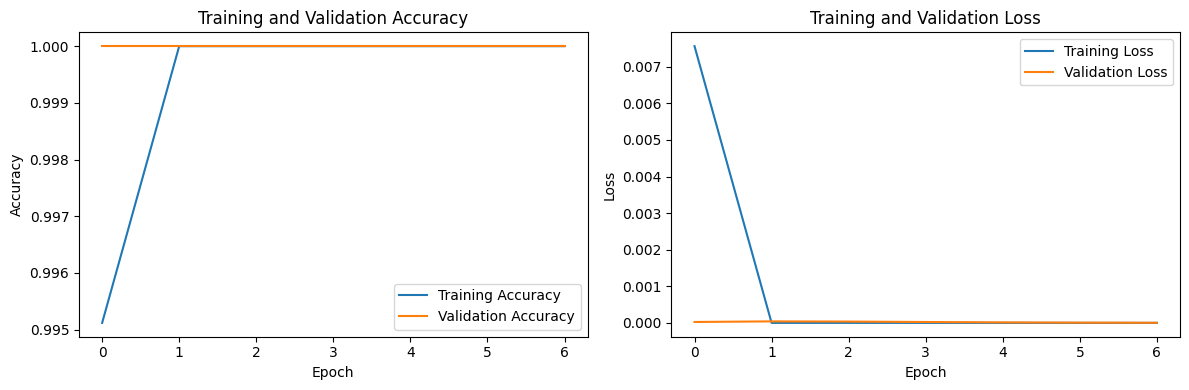

<Figure size 640x480 with 0 Axes>

In [8]:
# Plot training metrics
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

graph_path = '/Users/nadhiraprakosa/Documents/hell:kuliah/KP/lokalisasi segmentasi code/final files/graph/classificationgraph.png'
plt.savefig(graph_path)

Training Json File

In [15]:
import os
import json
import numpy as np
from keras.utils import Sequence

class CustomDataGenerator(Sequence):
    def __init__(self, json_dir, true_bbox, batch_size, image_size):
        self.json_dir = json_dir
        self.true_bbox = true_bbox
        self.batch_size = batch_size
        self.image_size = image_size
        self.image_width, self.image_height = image_size
        self.json_files = [filename for filename in os.listdir(json_dir) if filename.endswith('.json')]
        self.indexes = np.arange(len(self.json_files))
    
    def __len__(self):
        return int(np.ceil(len(self.json_files) / self.batch_size))
    
    def __getitem__(self, index):
        start = index * self.batch_size
        end = (index + 1) * self.batch_size
        batch_json_files = self.json_files[start:end]
        
        batch_images = []  # Placeholder for images (not loaded from file)
        batch_bbox = []    # Placeholder for bounding box coordinates
        
        for filename in batch_json_files:
            with open(os.path.join(self.json_dir, filename), 'r') as json_file:
                data = json.load(json_file)
                bbox = data[0]['bbox']  # Extract the 'bbox' list from the first dictionary in the list
                x1, y1, x2, y2 = bbox

                # Normalize bounding box coordinates to [0, 1]
                x1 = x1 / self.image_width
                y1 = y1 / self.image_height
                x2 = x2 / self.image_width
                y2 = y2 / self.image_height

        batch_bbox.append([x1, y1, x2, y2])
                
        return np.array(batch_images), np.array(batch_bbox)


In [16]:

# Directory paths for training and validation JSON annotation files
# Directory paths for training and validation JSON annotation files
TRAIN_JSON_DIR = '/Users/nadhiraprakosa/Documents/hell:kuliah/KP/lokalisasi segmentasi code/final files/annotation/train_json'
VALIDATION_JSON_DIR = '/Users/nadhiraprakosa/Documents/hell:kuliah/KP/lokalisasi segmentasi code/final files/annotation/val_json'

# Load true bounding box coordinates from training JSON files
train_true_bbox_list = []
for filename in os.listdir(TRAIN_JSON_DIR):
    if filename.endswith('.json'):
        with open(os.path.join(TRAIN_JSON_DIR, filename), 'r') as json_file:
            data = json.load(json_file)
            bbox = data[0]['bbox']  
            x1, y1, x2, y2 = bbox
            train_true_bbox_list.append([x1, y1, x2, y2])

# Convert the list of true bounding boxes to a numpy array for training
train_true_bbox = np.array(train_true_bbox_list)

# Load true bounding box coordinates from validation JSON files
validation_true_bbox_list = []
for filename in os.listdir(VALIDATION_JSON_DIR):
    if filename.endswith('.json'):
        with open(os.path.join(VALIDATION_JSON_DIR, filename), 'r') as json_file:
            data = json.load(json_file)
            bbox = data[0]['bbox']  # Extract the 'bbox' list from the first dictionary in the list
            x1, y1, x2, y2 = bbox
            validation_true_bbox_list.append([x1, y1, x2, y2])

# Convert the list of true bounding boxes to a numpy array for validation
validation_true_bbox = np.array(validation_true_bbox_list)

# Create custom data generators for training and validation
train_generator = CustomDataGenerator(TRAIN_JSON_DIR, train_true_bbox, batch_size=32, image_size=(256, 256))
validation_generator = CustomDataGenerator(VALIDATION_JSON_DIR, validation_true_bbox, batch_size=32, image_size=(256, 256))


In [23]:
from keras.callbacks import CSVLogger

json_model = Model(inputs=json_input, outputs=bbox_output)
json_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])

# Callback to log training metrics to CSV
csv_logger = CSVLogger('jsontraining_metrics.csv', separator=',', append=False)

history = json_model.fit(
    train_generator,
    epochs=7,
    steps_per_epoch=len(train_generator),
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    callbacks=[csv_logger]
)


Epoch 1/7
96/96 [==============================] - 1s 5ms/step - loss: 0.0000e+00 - mse: 0.0000e+00 - val_loss: 0.0000e+00 - val_mse: 0.0000e+00
Epoch 2/7
96/96 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - mse: 0.0000e+00 - val_loss: 0.0000e+00 - val_mse: 0.0000e+00
Epoch 3/7
96/96 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - mse: 0.0000e+00 - val_loss: 0.0000e+00 - val_mse: 0.0000e+00
Epoch 4/7
96/96 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - mse: 0.0000e+00 - val_loss: 0.0000e+00 - val_mse: 0.0000e+00
Epoch 5/7
96/96 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - mse: 0.0000e+00 - val_loss: 0.0000e+00 - val_mse: 0.0000e+00
Epoch 6/7
96/96 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - mse: 0.0000e+00 - val_loss: 0.0000e+00 - val_mse: 0.0000e+00
Epoch 7/7
96/96 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - mse: 0.0000e+00 - val_loss: 0.0000e+00 - val_m